In [1]:
import cython
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import community as community_louvain
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import fa2_modified as fa2
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import math
from wordcloud import WordCloud
import random
import matplotlib.colors as mcolors

## Load processed graph

In [3]:
# Path to your pickle file
pickle_file_path = "researchers_csai_graph_gcc_with_abstract.pkl"

with open(pickle_file_path, "rb") as f:
    G = pickle.load(f)

In [4]:
print(f'Graph has {len(G.nodes())} nodes')
print(f'Graph has {len(G.edges())} edges')

Graph has 162972 nodes
Graph has 2338729 edges


## Citations

The following part adds `citations` node feature which sums citations from distinct papers related to the researcher.

In [5]:
# Dictionary to store citation counts for each researcher (node)
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher (to avoid duplicates)
researcher_papers = defaultdict(set)

# Iterate over all edges in the graph
for u, v, edge_data in G.edges(data=True):
    # Access the title and citation count
    title = edge_data.get('title', None)
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    # Ensure title is valid
    if title:
        # For researcher u
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        
        # For researcher v
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Now researcher_citations contains total citation count for each researcher (node)
# Add the citations feature to each node in the graph
for researcher, total_citations in researcher_citations.items():
    if researcher in G.nodes:
        G.nodes[researcher]['citations'] = total_citations  # Add 'citations' feature to the node

In [6]:
# Dictionary to store citation counts for unique papers (deduplicated by title)
unique_paper_citations = {}

# Iterate over all edges in the graph to extract citation data
for u, v, edge_data in G.edges(data=True):
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    if title:  # Ensure the title is valid
        # If the title is not already in the dictionary, add it with its citation count
        if title not in unique_paper_citations:
            unique_paper_citations[title] = num_cited_by

# Extract citation counts for the unique papers
deduplicated_citation_counts = list(unique_paper_citations.values())

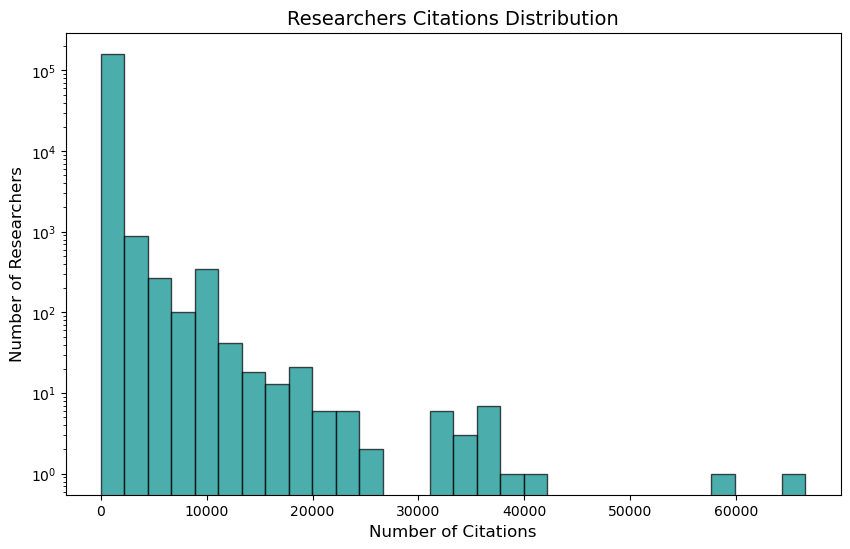

In [7]:
# Extract citation counts for each researcher (node)
researcher_citation_counts = [G.nodes[node].get('citations', 0) for node in G.nodes]

# Plotting the citation counts
plt.figure(figsize=(10, 6))
plt.hist(
    researcher_citation_counts,
    bins=30,
    color="darkcyan",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")  # Set y-axis to logarithmic scale

plt.title("Researchers Citations Distribution", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Researchers", fontsize=12)

plt.show()


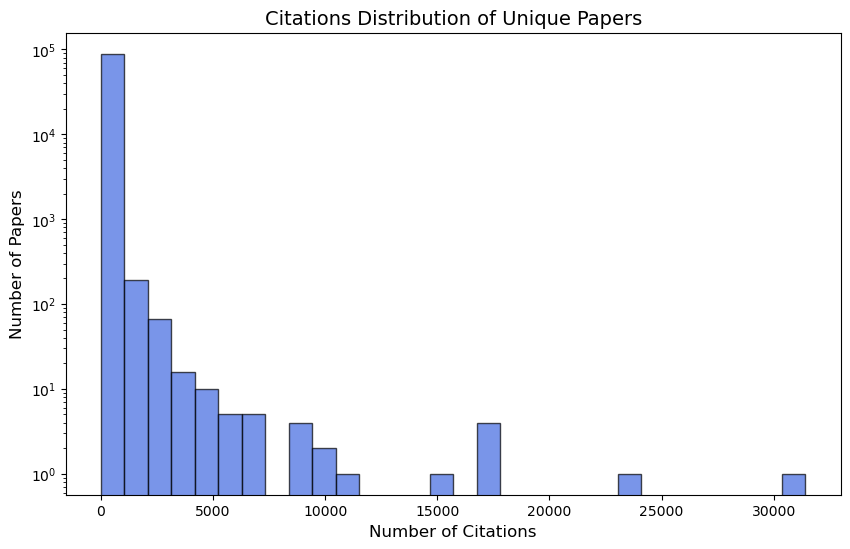

In [8]:
# Plotting the citation counts for unique papers
plt.figure(figsize=(10, 6))
plt.hist(
    deduplicated_citation_counts,
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")  # Set y-axis to logarithmic scale

plt.title("Citations Distribution of Unique Papers", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)

plt.show()

As expected, we have a seriousely right-skewed citations distribution. Few papers enjoy very high number of citations and most papers get only a couple.

In [9]:
# Extract deduplicated citation data and associated paper metadata
deduplicated_paper_citations = [
    (title, citation_count) for title, citation_count in unique_paper_citations.items()
]

# Sort papers by citation count in descending order
sorted_deduplicated_papers = sorted(
    deduplicated_paper_citations, key=lambda x: x[1], reverse=True
)

# Get the top 10 papers
top_10_papers = sorted_deduplicated_papers[:10]

# Print the top 10 papers
print("Top Papers with Most Citations (Deduplicated by Title):\n")
for i, (title, citations) in enumerate(top_10_papers, 1):
    print(f"{i}. {title} - Citations: {citations}")


Top Papers with Most Citations (Deduplicated by Title):

1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - Citations: 31414
2. SMOTE: Synthetic Minority Over-sampling Technique - Citations: 23278
3. A Unified Approach to Interpreting Model Predictions - Citations: 17703
4. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification - Citations: 17689
5. Graph Attention Networks - Citations: 17607
6. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization - Citations: 17416
7. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier - Citations: 15069
8. Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks - Citations: 10801
9. Conditional Generative Adversarial Nets - Citations: 9774
10. Training language models to follow instructions with human feedback - Citations: 9614


TO DO: 
- Do small research on them to tell a story. Looks like these are well aclaimed papers.

In [10]:
# Dictionary to store total citations for each researcher
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher
researcher_papers = defaultdict(set)

# Traverse edges to aggregate citation counts for each researcher
for u, v, edge_data in G.edges(data=True):
    # Access citation-related attributes and title
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)
    
    # Ensure the title is valid
    if title:
        # Add citations for each researcher, ensuring the paper is counted only once
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Sort researchers by total citations (descending)
sorted_researcher_citations = sorted(researcher_citations.items(), key=lambda x: x[1], reverse=True)

# Print the top researchers by total citations
print("Top Researchers by Total Citations (Deduplicated by Paper):\n")
for i, (researcher, total_citations) in enumerate(sorted_researcher_citations[:10], 1):  # Adjust the range for more/less
    print(f"{i}. {researcher} - Total Citations: {total_citations}")

Top Researchers by Total Citations (Deduplicated by Paper):

1. S. Levine - Total Citations: 66585
2. P. Abbeel - Total Citations: 59345
3. Alexey Dosovitskiy - Total Citations: 41593
4. Quoc V. Le - Total Citations: 38176
5. Lucas Beyer - Total Citations: 36650
6. Xiaohua Zhai - Total Citations: 36520
7. N. Houlsby - Total Citations: 36510
8. Alexander Kolesnikov - Total Citations: 36492
9. Mostafa Dehghani - Total Citations: 36346
10. Yoshua Bengio - Total Citations: 36330


TO DO: 
- Look into whether it is one or many papers for them. 
- Do small research for a story. 
- No women? - cover on that.

## Filter out low citations edges

From now on, we are focusing only on the most valuable papers judged by number of citations. We are filtering out papers with less than 25 citations.

In [11]:
# Find edges with below 25 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 25
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [12]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG = G_filtered.subgraph(giant_component).copy()

In [13]:
# with open("graphs/RG.pkl", "wb") as file:
#     pickle.dump(RG, file)

In [14]:
print(f'Filtered graph has {len(RG.nodes())} nodes')
print(f'Filtered graph has {len(RG.edges())} edges')

Filtered graph has 39314 nodes
Filtered graph has 1015840 edges


In [15]:
# Set to store unique titles
unique_titles = set()

# Iterate over all edges in the RG graph
for _, _, edge_data in RG.edges(data=True):
    # Access the title
    title = edge_data.get('title', None)
    
    # Ensure the title is valid and add it to the set
    if title:
        unique_titles.add(title)

# Number of unique papers (deduplicated edges)
num_unique_papers = len(unique_titles)

print(f"Number of unique papers: {num_unique_papers}")

Number of unique papers: 26709


## Degree distribution

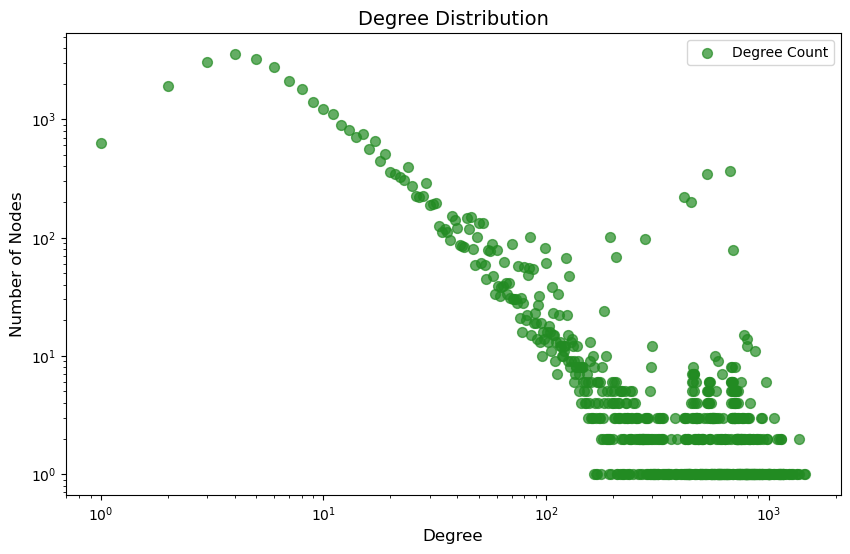

In [16]:
# Get the degree of each node
degrees = [d for _, d in RG.degree()]

# Count the frequency of each degree
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="forestgreen", alpha=0.7, s=50, label="Degree Count")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

Power-law degree distribution. We are dealing with scale-free network.

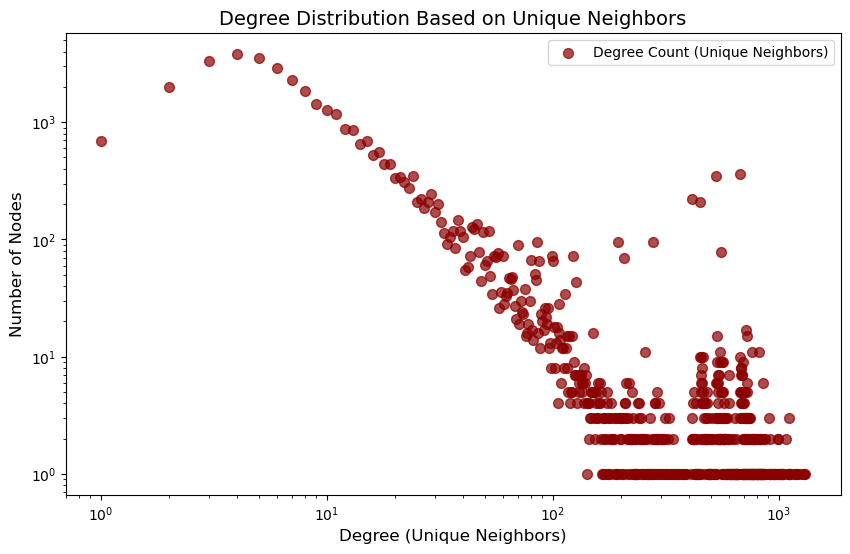

In [17]:
# Calculate degree based on unique neighbors
unique_neighbor_degrees = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Count the frequency of each degree
degree_counts = {}
for degree in unique_neighbor_degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="darkred", alpha=0.7, s=50, label="Degree Count (Unique Neighbors)")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution Based on Unique Neighbors", fontsize=14)
plt.xlabel("Degree (Unique Neighbors)", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

This second graph is calculated based on unique neighbours rather than number of edges. It does matter in case of MultiGraph but turns out the results are almost the same. This means that if we were to disregard multiple papers between two given researchers and just focus on whether they colaborated it wouldn't change the results in terms of degree.

TO DO: 
- In multigraphs, two nodes can have multiple edges between them. Check how it impacts the degree.
- Address the friendship paradox?

In [18]:
# Compute the degrees of all nodes
degrees = dict(RG.degree())

# Sort nodes by degree in descending order
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_degrees[:10]

# Display results
print("Top 10 nodes with highest degree:\n")
for node, degree in top_10_nodes:
    print(f"{node} - {degree}")

Top 10 nodes with highest degree:

Siamak Shakeri - 1462
Noah Fiedel - 1439
O. Vinyals - 1368
Ambrose Slone - 1368
Behnam Neyshabur - 1366
D. Hassabis - 1347
Michael B. Chang - 1344
Andrew M. Dai - 1285
Ethan Dyer - 1268
Vedant Misra - 1262


In [19]:
# Compute the number of unique neighbors for each node
unique_neighbors = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Sort nodes by the number of unique neighbors in descending order
sorted_unique_neighbors = sorted(unique_neighbors.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_unique_neighbors[:10]

# Display results
print("Top 10 nodes with the most unique neighbors:\n")
for node, count in top_10_nodes:
    print(f"{node} - {count}")

Top 10 nodes with the most unique neighbors:

Siamak Shakeri - 1311
Noah Fiedel - 1297
Behnam Neyshabur - 1283
Ambrose Slone - 1241
Andrew M. Dai - 1210
Ethan Dyer - 1193
Vedant Misra - 1191
Luheng He - 1171
Harsh Mehta - 1122
Rosanne Liu - 1119


Although both prints include similar reserachers the second print seems better for interpretation. It says that these researchers collaborated with the highest number of other researchers withing AI space.

TO DO:
- check if it is because of high average number of collaborations on paper or many papers

## Convert MultiGraph to regular Graph for some parts of analysis

In [20]:
def multigraph_to_weighted_graph(multigraph):
    """
    Convert a MultiGraph to a regular Graph with weighted edges.
    
    Edge weight is the sum of citations (`numCitedBy`) for all unique papers
    (identified by the `title` attribute) between two nodes.
    
    Parameters:
    - multigraph: A NetworkX MultiGraph with `title` and `numCitedBy` attributes on edges.
    
    Returns:
    - weighted_graph: A NetworkX Graph with computed weights on edges.
    """
    # Dictionary to store weights for edges in the new graph
    edge_weights = defaultdict(lambda: defaultdict(int))

    # Iterate through all edges in the MultiGraph
    for u, v, edge_data in multigraph.edges(data=True):
        title = edge_data.get("title")
        num_cited_by = edge_data.get("numCitedBy", 0)

        # Ensure we consider unique papers by `title`
        if title:
            # Add the citation count to the edge weight for the (u, v) edge, using the title as a key
            edge_weights[(u, v)][title] = num_cited_by

    # Create a new regular graph
    weighted_graph = nx.Graph()

    # Add weighted edges to the new graph
    for (u, v), title_dict in edge_weights.items():
        # Sum up the citations for all unique papers between u and v
        total_weight = sum(title_dict.values())
        weighted_graph.add_edge(u, v, weight=total_weight)

    return edge_weights, weighted_graph

In [21]:
edge_weights, weighted_RG = multigraph_to_weighted_graph(RG)
RG_regular = nx.Graph(RG)

print(f'RG Multigraph: \n Nodes: {len(RG.nodes())}\n Edges: {len(RG.edges())}\n')
print(f'RG Regular: \n Nodes: {len(RG_regular.nodes())}\n Edges: {len(RG_regular.edges())}')

RG Multigraph: 
 Nodes: 39314
 Edges: 1015840

RG Regular: 
 Nodes: 39314
 Edges: 942607


In [ ]:
# with open("graphs/RG_regular.pkl", "wb") as file:
#     pickle.dump(RG_regular, file)

The difference in edges is very small and this explains why it does not matter whether we calulate degree based on number of edges or number of unique neighbours.

## Network Visualization

#### Thresholding filter

In [22]:
def thesholding_filter(graph, alpha=0.1):
    """
    Apply the thesholding filter to a weighted graph by retaining edges whose disparity is higher than a threshold.
    The threshold is calculated as alpha * max_disparity.

    Parameters:
    - graph: The input weighted graph (NetworkX Graph).
    - alpha: The threshold parameter to filter edges based on their disparity.

    Returns:
    - filtered_graph: A new graph containing only the significant edges (filtered backbone).
    """

    # Calculate the total weight of each node (sum of edge weights)
    node_weights = {node: sum(weight for _, _, weight in graph.edges(node, data='weight')) for node in graph.nodes}

    # Calculate disparity for each edge
    edge_disparity = {}
    for u, v, weight in graph.edges(data=True):
        w_ij = weight['weight']
        w_i = node_weights.get(u, 0)
        w_j = node_weights.get(v, 0)
        
        # Prevent division by zero
        if w_i + w_j > 0:
            disparity = w_ij / (w_i + w_j)  # Disparity measure
            edge_disparity[(u, v)] = disparity
        else:
            edge_disparity[(u, v)] = 0  # Assign zero disparity if node weight is zero

    # Find the maximum disparity value
    max_disparity = max(edge_disparity.values(), default=0)

    # Calculate the threshold
    threshold = alpha * max_disparity

    # Filter edges: keep edges where disparity is greater than or equal to the threshold
    filtered_edges = [(u, v) for (u, v), disparity in edge_disparity.items() if disparity >= threshold]

    # Create a subgraph with the filtered edges
    filtered_graph = graph.edge_subgraph(filtered_edges).copy()

    return filtered_graph

#### Alpha 0.1

In [23]:
alpha_value = 0.1  # Adjust alpha to tune the number of edges kept
filtered_backbone_point_1 = thesholding_filter(weighted_RG, alpha=alpha_value)

In [ ]:
num_nodes_weighted_RG = len(weighted_RG.nodes)
num_edges_weighted_RG = len(weighted_RG.edges)

num_nodes_filtered_backbone = len(filtered_backbone_point_1.nodes)
num_edges_filtered_backbone = len(filtered_backbone_point_1.edges)

print(f"Summary of weighted_RG graph:")
print(f"Number of nodes: {num_nodes_weighted_RG}")
print(f"Number of edges: {num_edges_weighted_RG}")

print(f"\nSummary of filtered_backbone graph:")
print(f"Number of nodes: {num_nodes_filtered_backbone}")
print(f"Number of edges: {num_edges_filtered_backbone}")

In [ ]:
# Takes about 1h to run
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

positions_alpha_point_1 = forceatlas2.forceatlas2_networkx_layout(filtered_backbone_point_1, pos=None, iterations=1000)

In [ ]:
# Save positions
# with open("positions_alpha_point_1.pkl", "wb") as file:
#     pickle.dump(positions_alpha_point_1, file)

In [ ]:
# Read positions
with open("positions_alpha_point_1.pkl", "rb") as file:
    positions_alpha_point_1 = pickle.load(file)

In [ ]:
# Nodes proportional to degree
node_degrees = [filtered_backbone_point_1.degree(node) for node in filtered_backbone_point_1.nodes]
min_size, max_size = 10, 100
node_sizes = [min_size + (max_size - min_size) * (degree / max(node_degrees)) for degree in node_degrees]

fig, ax = plt.subplots(figsize=(15, 15))

graph_plot = nx.draw(
    filtered_backbone_point_1,
    pos=positions_alpha_point_1,
    node_size=node_sizes,
    edge_color="black",
    width=3.0,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

plt.title("Network Visualization with Node Sizes Proportional to Degree", fontsize=14)
plt.show()

Because of too high theshold the network is very disconnected.

#### Alpha 0.03

In [ ]:
alpha_value = 0.03  # Adjust alpha to tune the number of edges kept
filtered_backbone_point_03 = thesholding_filter(weighted_RG, alpha=alpha_value)

In [ ]:
num_nodes_weighted_RG = len(weighted_RG.nodes)
num_edges_weighted_RG = len(weighted_RG.edges)

num_nodes_filtered_backbone = len(filtered_backbone_point_03.nodes)
num_edges_filtered_backbone = len(filtered_backbone_point_03.edges)

print(f"Summary of weighted_RG graph:")
print(f"Number of nodes: {num_nodes_weighted_RG}")
print(f"Number of edges: {num_edges_weighted_RG}")

print(f"\nSummary of filtered_backbone graph:")
print(f"Number of nodes: {num_nodes_filtered_backbone}")
print(f"Number of edges: {num_edges_filtered_backbone}")

In [ ]:
# Takes 2-3h to run
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=1.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

positions_alpha_point_03 = forceatlas2.forceatlas2_networkx_layout(filtered_backbone_point_03, pos=None, iterations=1000)

In [ ]:
# Save positions

# with open("positions_alpha_point_03.pkl", "wb") as file:
#     pickle.dump(positions_alpha_point_03, file)

In [ ]:
# Read positions
with open("positions_alpha_point_03.pkl", "rb") as file:
    positions_alpha_point_03 = pickle.load(file)

In [ ]:
# Nodes sizes based on degree
node_degrees = [filtered_backbone_point_03.degree(node) for node in filtered_backbone_point_03.nodes]
min_size, max_size = 10, 100
node_sizes = [min_size + (max_size - min_size) * (degree / max(node_degrees)) for degree in node_degrees]

fig, ax = plt.subplots(figsize=(15, 15))

graph_plot = nx.draw(
    filtered_backbone_point_03,
    pos=positions_alpha_point_03,
    node_size=node_sizes,
    edge_color="black",
    width=3.0,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

plt.title("Network Visualization with Node Sizes Proportional to Degree", fontsize=14)
plt.show()

Netowrk is stil disconnected but looks better.

#### Alpha 0.03 different position config

In [ ]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=2.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=1.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions_alpha_point_03_high_edgeinf = forceatlas2.forceatlas2_networkx_layout(filtered_backbone_point_03, pos=None, iterations=1000)

In [ ]:
# with open("positions_alpha_point_03_high_edgeinf.pkl", "wb") as file:
#     pickle.dump(positions_alpha_point_03_high_edgeinf, file)

In [ ]:
# with open("positions_alpha_point_03_high_edgeinf.pkl", "rb") as file:
#     positions_alpha_point_03_high_edgeinf = pickle.load(file)

In [ ]:
# Prepare node sizes based on node degree
node_degrees = [filtered_backbone_point_03.degree(node) for node in filtered_backbone_point_03.nodes]
min_size, max_size = 10, 100
node_sizes = [min_size + (max_size - min_size) * (degree / max(node_degrees)) for degree in node_degrees]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    filtered_backbone_point_03,
    pos=positions_alpha_point_03_high_edgeinf,
    node_size=1.0,
    edge_color="grey",
    node_color="darkcyan",
    width=1.0,
    alpha=0.5,
    with_labels=False,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization", fontsize=14)
plt.show()

Try the same with GCC extracted.

In [ ]:
connected_components = list(nx.connected_components(filtered_backbone_point_03))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
backbone_gcc = filtered_backbone_point_03.subgraph(giant_component).copy()

In [ ]:
# Prepare node sizes based on node degree
node_degrees = [filtered_backbone_point_03.degree(node) for node in filtered_backbone_point_03.nodes]
min_size, max_size = 10, 100
node_sizes = [min_size + (max_size - min_size) * (degree / max(node_degrees)) for degree in node_degrees]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    backbone_gcc,
    pos=positions_alpha_point_03_high_edgeinf,
    node_size=1.0,
    edge_color="grey",
    node_color="darkcyan",
    width=1.0,
    alpha=0.5,
    with_labels=False,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization", fontsize=14)
plt.show()

Sizes according to citations

In [ ]:
# Map citation counts to node sizes
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_gcc,
    pos=positions_alpha_point_03_high_edgeinf,
    node_size=node_sizes,
    edge_color="grey",
    node_color="darkcyan",
    width=1.0,
    alpha=0.5,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Node Sizes", fontsize=14)
plt.show()

Sizes - degree, Colors - citations

In [ ]:
# Node sizes based on degree
min_size, max_size = 1, 20
degrees = [backbone_gcc.degree(node) for node in backbone_gcc.nodes]
if max(degrees) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (degree / max(degrees)) for degree in degrees]
else:
    node_sizes = [min_size for _ in backbone_gcc.nodes]

# Node colors based on citations
citations = [researcher_citations.get(node, 0) for node in backbone_gcc.nodes]
if max(citations) > 0:  # Normalize citations for color mapping
    norm = mcolors.Normalize(vmin=min(citations), vmax=max(citations))
    cmap = cm.viridis  # Use the Viridis colormap
    node_colors = [cmap(norm(citation)) for citation in citations]
else:
    node_colors = ["lightgrey" for _ in backbone_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_gcc,
    pos=positions_alpha_point_03_high_edgeinf,
    node_size=node_sizes,  # Degree-based sizes
    edge_color="grey",
    node_color=node_colors,  # Citation-based colors
    width=1.0,
    alpha=0.5,
    ax=ax
)

# Add a colorbar for the citation values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Citations", fontsize=12)

# Set the title and show the plot
plt.title("Network Visualization with Degree-Based Sizes and Citation-Based Colors", fontsize=14)
plt.show()

Problem in general is that the most interesting (with highest citations) papers are in the middle of this hairball and it is hard to uncover them.

The following section was tried at first to draw a graph filtered down to 100 citations by just removing nodes and extracting the giant connected component (simpler approach than thresholding above).

In [ ]:
# Find edges with below 50 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 100
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [ ]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG_100 = G_filtered.subgraph(giant_component).copy()

In [ ]:
# Convert the multigraph to a regular graph where two nodes can have only one edge
RG_100_regular = nx.Graph(RG_100)

In [ ]:
print(f'Filtered graph has {len(RG_100_regular.nodes())} nodes')
print(f'Filtered graph has {len(RG_100_regular.edges())} edges')

In [ ]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions = forceatlas2.forceatlas2_networkx_layout(RG_100_regular, pos=None, iterations=2000)

In [ ]:
# with open("positions.pkl", "wb") as file:
#     pickle.dump(positions, file)

In [ ]:
# Node size: Scale according to 'citations' attribute
min_size, max_size = 10, 1000  # Node size range
citations = nx.get_node_attributes(RG_100_regular, 'citations')  # Get node 'citations' attribute
max_citations = max(citations.values(), default=1)
node_sizes = [
    min_size + (max_size - min_size) * (citations.get(node, 0) / max_citations)
    for node in RG_100_regular.nodes
]

# Node color: Scale according to node degree
node_degrees = [RG_100_regular.degree(node) for node in RG_100_regular.nodes]
norm = mcolors.Normalize(vmin=min(node_degrees), vmax=max(node_degrees))  # Normalize degree
cmap = cm.viridis  # Choose a color map
node_colors = [cmap(norm(degree)) for degree in node_degrees]

# Edge intensity: Scale edge width and transparency by 'numCitedBy' attribute
edge_citations = nx.get_edge_attributes(RG_100_regular, 'numCitedBy')  # Get edge 'numCitedBy' attribute
max_edge_citations = max(edge_citations.values(), default=1)
edge_weights = [
    0.5 + 2.5 * (edge_citations.get((u, v), 0) / max_edge_citations)
    for u, v in RG_100_regular.edges
]
edge_alphas = [
    0.2 + 0.8 * (edge_citations.get((u, v), 0) / max_edge_citations)
    for u, v in RG_100_regular.edges
]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw edges first (with transparency)
for (u, v), width, alpha in zip(RG_100_regular.edges, edge_weights, edge_alphas):
    nx.draw_networkx_edges(
        RG_100_regular,
        pos=positions,
        edgelist=[(u, v)],
        width=width,
        alpha=alpha,
        edge_color="gray",
        ax=ax,
    )

# Draw nodes
nx.draw_networkx_nodes(
    RG_100_regular,
    pos=positions,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cmap,
    ax=ax,
)

# Add a color bar for node colors (degrees)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Node Degree", fontsize=12)

# Set title and show the plot
plt.title("Network Visualization with Scaled Node Size, Color, and Edge Intensity", fontsize=14)
plt.show()

Results are not good.

#### Disparity filter

In [35]:
def disparity_filter(graph, alpha=0.1):
    """
    Apply the disparity filter to a weighted graph using the statistical p-value-based method.

    Parameters:
    - graph: The input weighted graph (NetworkX Graph).
    - alpha: The significance level to filter edges.

    Returns:
    - filtered_graph: A new graph containing only the significant edges (filtered backbone).
    """
    filtered_edges = []
    
    for node in graph.nodes:
        neighbors = list(graph.neighbors(node))
        k_i = len(neighbors)  # Degree of the node
        if k_i < 2:
            continue  # Skip nodes with degree < 2
        
        total_weight = sum(graph[node][neighbor]['weight'] for neighbor in neighbors)
        
        # Skip nodes with zero total weight
        if total_weight == 0:
            continue
        
        for neighbor in neighbors:
            w_ij = graph[node][neighbor]['weight']
            p_ij = w_ij / total_weight
            
            # Compute p-value α_ij = (1 - p_ij)^(k_i - 1)
            alpha_ij = (1 - p_ij) ** (k_i - 1)
            
            # Keep edge if α_ij <= alpha
            if alpha_ij <= alpha:
                filtered_edges.append((node, neighbor, w_ij))
    
    # Create a subgraph with the filtered edges
    filtered_graph = nx.Graph()
    filtered_graph.add_weighted_edges_from(filtered_edges)
    
    return filtered_graph

In [36]:
backbone_disparity = disparity_filter(weighted_RG)

connected_components = list(nx.connected_components(backbone_disparity))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
backbone_disparity_gcc = backbone_disparity.subgraph(giant_component).copy()

In [ ]:
num_nodes_weighted_RG = len(weighted_RG.nodes)
num_edges_weighted_RG = len(weighted_RG.edges)

num_nodes_filtered_backbone = len(backbone_disparity_gcc.nodes)
num_edges_filtered_backbone = len(backbone_disparity_gcc.edges)

print(f"Summary of weighted_RG graph:")
print(f"Number of nodes: {num_nodes_weighted_RG}")
print(f"Number of edges: {num_edges_weighted_RG}")

print(f"\nSummary of filtered_backbone graph:")
print(f"Number of nodes: {num_nodes_filtered_backbone}")
print(f"Number of edges: {num_edges_filtered_backbone}")

In [ ]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=2.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=1.2,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions_backbone_disparity = forceatlas2.forceatlas2_networkx_layout(backbone_disparity_gcc, pos=None, iterations=1000)

with open("positions_backbone_disparity.pkl", "wb") as file:
    pickle.dump(positions_backbone_disparity, file)

In [ ]:
with open("positions_backbone_disparity.pkl", "rb") as file:
    positions_backbone_disparity = pickle.load(file)

In [ ]:
# Node sizes based on degree
min_size, max_size = 1, 100
degrees = [backbone_disparity_gcc.degree(node) for node in backbone_disparity_gcc.nodes]
if max(degrees) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (degree / max(degrees)) for degree in degrees]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Node colors based on citations
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Normalize citations for color mapping
    norm = mcolors.Normalize(vmin=min(citations), vmax=max(citations))
    cmap = cm.viridis  # Use the Viridis colormap
    node_colors = [cmap(norm(citation)) for citation in citations]
else:
    node_colors = ["lightgrey" for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Degree-based sizes
    edge_color="grey",
    node_color=node_colors,  # Citation-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a colorbar for the citation values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Citations", fontsize=12)

# Set the title and show the plot
plt.title("Network Visualization with Degree-Based Sizes and Citation-Based Colors", fontsize=14)
plt.show()

## Clustering coefficient

In [ ]:
# Compute the clustering coefficient for each node
node_clustering = nx.clustering(RG_regular)
average_clustering = nx.average_clustering(RG_regular)
print("Average Clustering Coefficient:", average_clustering)

In [66]:
# Compute the degree for each node
node_degrees = dict(RG_regular.degree())

# Prepare data for plotting
degrees = list(node_degrees.values())  # degree of each node
clustering_coeffs = list(node_clustering.values())  # clustering coefficient of each node

In [ ]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color="royalblue", alpha=0.7, edgecolor="black")

# Set y-axis to logarithmic scale
plt.yscale("log")

# Title and labels
plt.title("Histogram of Clustering Coefficients", fontsize=14)
plt.xlabel("Clustering Coefficient", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Most researchers have a clustering coefficient close or equal to 1. It is however tricky to interpret in our case since if we have 20 researchers working on the same paper obviousely they will all be fully connected with each other.

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, clustering_coeffs, color="forestgreen", alpha=0.7, s=50)

# Set the title and labels
plt.title("Degree vs Clustering Coefficient", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Clustering Coefficient", fontsize=12)

# Show the plot
plt.show()

What is a bit suprprising here is that researchers with high degree almost always have a high clustering coefficient. It might that those researchers enjoy high degree because of many people working on the same paper.

TO DO:
- check the reason for researchers having top degree levels

## Assortativity

In [ ]:
assortativity = nx.degree_assortativity_coefficient(RG_regular)

# Print the result
print("Degree Assortativity Coefficient:", assortativity)

Very high degree assortativity. Typical for social networks. Maybe more so in reasearchs network.

TO DO:
- Think about whether we can get some interesting node attributes for our researchers based on which we could calculate assortativity. E.g. country, university, field of research typical? 

# Communities

In [22]:
# Load partition to make sure it is running on the correct split
with open("partition.pkl", "rb") as file:
    partition = pickle.load(file)

In [23]:
# Group nodes by community
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Calculate the total number of communities and average number of nodes
num_communities = len(communities)
node_counts = [len(nodes) for nodes in communities.values()]
average_nodes_per_community = sum(node_counts) / num_communities if num_communities > 0 else 0

# Print the summary
print(f"Total number of communities: {num_communities}")
print(f"Average number of nodes per community: {average_nodes_per_community:.2f}")

Total number of communities: 73
Average number of nodes per community: 538.55


We want to find the most relevant communities. For that, we'll look into three metrics

- Size of the community: How many researchers are in the community.
- Modularity contribution: How much of the total edges are internal edges.
- Average citations per researcher: How much citations the researchers in the community have on average.

### a) Find the largest communities

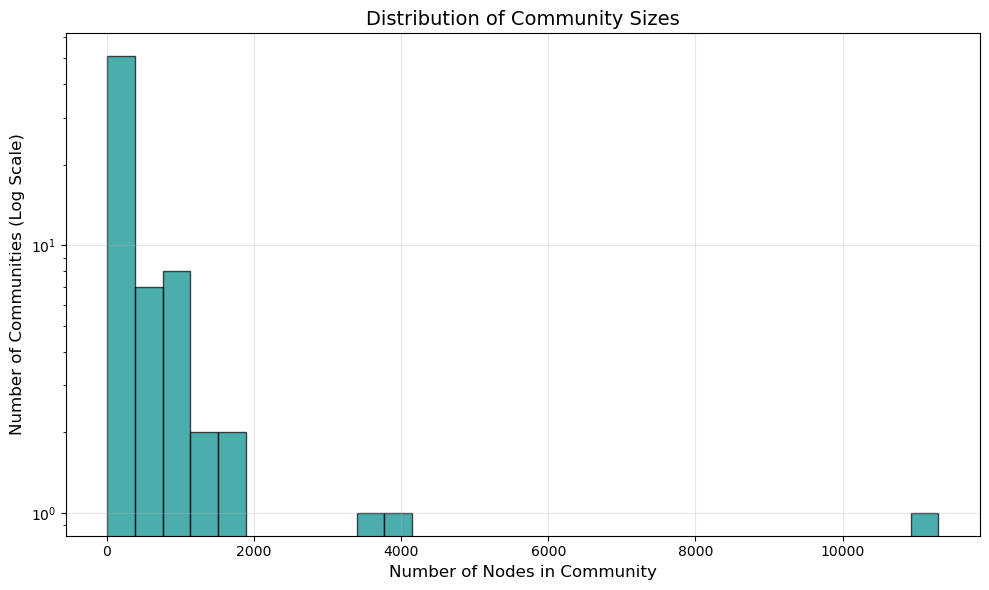

In [24]:
# Get community sizes
community_sizes = [len(nodes) for _, nodes in communities.items()]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    community_sizes, 
    bins=30,
    color="darkcyan",
    alpha=0.7,
    edgecolor="black"
)

# Set y-axis to logarithmic scale since community sizes often follow power law
plt.yscale("log")

# Add labels and title
plt.title("Distribution of Community Sizes", fontsize=14)
plt.xlabel("Number of Nodes in Community", fontsize=12)
plt.ylabel("Number of Communities (Log Scale)", fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Sort communities by size in descending order
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

# Print the 5 largest communities
print("Communities with highest # nodes, descending:")
print("")
for i, (comm_id, nodes) in enumerate(sorted_communities[:10], 1):
    print(f"{i}. Community {comm_id}: {len(nodes)} nodes")

Communities with highest # nodes, descending:

1. Community 1: 11302 nodes
2. Community 0: 3910 nodes
3. Community 9: 3575 nodes
4. Community 21: 1878 nodes
5. Community 10: 1549 nodes
6. Community 60: 1375 nodes
7. Community 28: 1194 nodes
8. Community 42: 1124 nodes
9. Community 6: 1104 nodes
10. Community 31: 1059 nodes


### b) Find Communities with highest modularity contribution

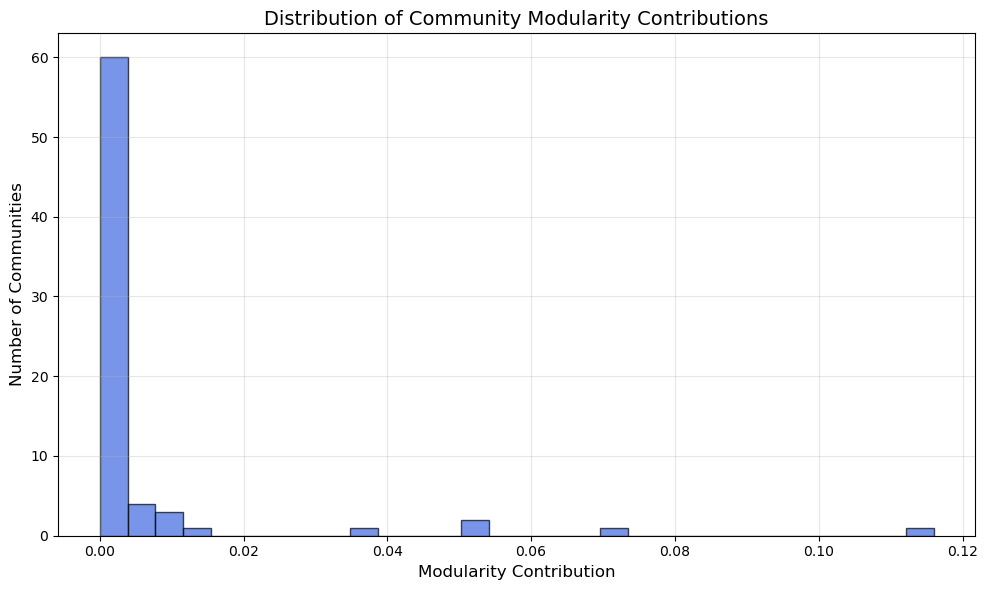

In [26]:
# Calculate modularity contribution for each community
community_modularity_contribution = {}
for comm_id, nodes in communities.items():
    # Get all edges between nodes in this community
    internal_edges = RG_regular.subgraph(nodes).edges()
    internal_edges_count = len(internal_edges)
    
    # Get all edges connected to nodes in this community
    total_edges = sum(RG_regular.degree(node) for node in nodes)
    
    # Calculate modularity contribution
    # Q_i = (internal edges / total edges) - (total degree / (2 * total edges))^2
    m = RG_regular.number_of_edges()
    modularity_contribution = (internal_edges_count / (2 * m)) - (total_edges / (4 * m))**2
    community_modularity_contribution[comm_id] = modularity_contribution

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    list(community_modularity_contribution.values()),
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

# Add labels and title
plt.title("Distribution of Community Modularity Contributions", fontsize=14)
plt.xlabel("Modularity Contribution", fontsize=12)
plt.ylabel("Number of Communities", fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# You might want to set y-axis to log scale if the distribution is very skewed
# plt.yscale("log")  # Uncomment if needed

plt.tight_layout()
plt.show()

In [27]:
# Sort communities by modularity contribution in descending order
sorted_by_modularity = sorted(community_modularity_contribution.items(), key=lambda x: x[1], reverse=True)

# Print the 5 communities with highest modularity contribution
print("Communities with highest modularity contribution, descending:")
print("")
for i, (comm_id, mod) in enumerate(sorted_by_modularity[:10], 1):
    print(f"{i}. Community {comm_id}: Modularity Contribution: {mod:.4f}")

Communities with highest modularity contribution, descending:

1. Community 6: Modularity Contribution: 0.1160
2. Community 23: Modularity Contribution: 0.0702
3. Community 25: Modularity Contribution: 0.0531
4. Community 2: Modularity Contribution: 0.0529
5. Community 1: Modularity Contribution: 0.0366
6. Community 0: Modularity Contribution: 0.0129
7. Community 31: Modularity Contribution: 0.0112
8. Community 60: Modularity Contribution: 0.0089
9. Community 9: Modularity Contribution: 0.0086
10. Community 21: Modularity Contribution: 0.0068


### c) Find Communities with highest average citations per researchers

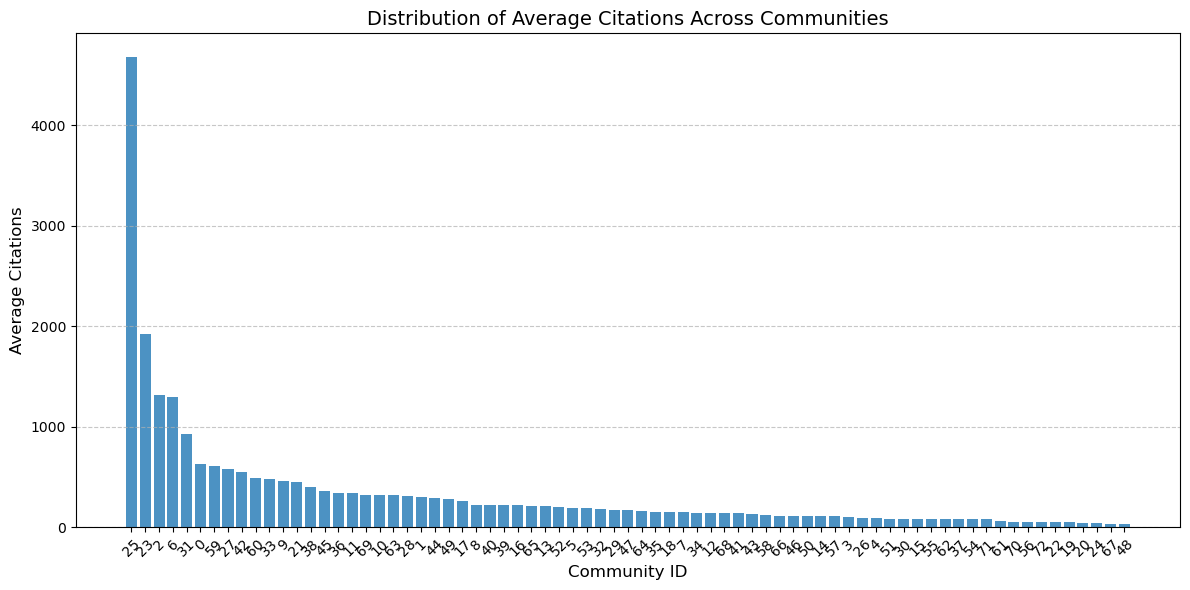

In [28]:
researcher_citations = dict(sorted_researcher_citations)

citations_community_total = {community: 0 for community in communities.keys()}
citations_community_avg = {community: 0 for community in communities.keys()}

for community in communities.keys():
    for node in communities[community]:
        citations_community_total[community] += researcher_citations[node]
    citations_community_avg[community] = citations_community_total[community] / len(communities[community])

# Sort communities by average citations (descending)
sorted_communities_by_avg = sorted(citations_community_avg.items(), key=lambda x: x[1], reverse=True)

# Create a bar plot for average citations per community
plt.figure(figsize=(12, 6))
plt.bar(range(len(citations_community_avg)), 
        [citations for _, citations in sorted_communities_by_avg],
        alpha=0.8)

plt.title('Distribution of Average Citations Across Communities', fontsize=14)
plt.xlabel('Community ID', fontsize=12)
plt.ylabel('Average Citations', fontsize=12)

# Add community IDs as x-tick labels
plt.xticks(range(len(citations_community_avg)), 
           [community for community, _ in sorted_communities_by_avg],
           rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [29]:
# Sort communities by average citations (descending)
sorted_communities_by_avg = sorted(citations_community_avg.items(), key=lambda x: x[1], reverse=True)

# Print top 5 communities with highest average citations
print("Communities with highest average citation per researcher, descending:")
print("")
for i, (community, avg_citations) in enumerate(sorted_communities_by_avg[:10], 1):
    print(f"{i}. Community {community}: Average Citations: {avg_citations:.2f}")

Communities with highest average citation per researcher, descending:

1. Community 25: Average Citations: 4680.64
2. Community 23: Average Citations: 1922.91
3. Community 2: Average Citations: 1317.72
4. Community 6: Average Citations: 1297.80
5. Community 31: Average Citations: 932.10
6. Community 0: Average Citations: 624.65
7. Community 59: Average Citations: 610.46
8. Community 27: Average Citations: 581.41
9. Community 42: Average Citations: 545.48
10. Community 60: Average Citations: 487.39


**Interpretation**

We find that there is a strong overlap between the communities with highest modularity contribution and the communities with highest average citations per researcher, with communities [6, 23, 25, 2, 0, 31, 60] all being in the top 10 of the two metrics. This means that we have found four commuinities, that are not only working more closely together than all other communities, but produce also more relevant findings. We will further investigate these communities of interest.

Community size on the other hand does not seem to contribute much to this analysis, so we are not investigating it further. 

In [72]:
# List of specific communities to include
communities_of_interest = [25, 23, 2, 6, 31, 0, 60]

# Create a list to store the data for each community
community_data = []

# Gather data for each specified community
for community in communities_of_interest:
    # Get number of nodes in the community
    num_nodes = len(communities[community])
    # Get modularity contribution
    mod_contribution = community_modularity_contribution[community]
    # Get average citations
    avg_citations = citations_community_avg[community]
    
    # Add the data to our list
    community_data.append([
        community,
        num_nodes,
        mod_contribution,
        avg_citations
    ])

# Sort the data by node size in descending order
community_data.sort(key=lambda x: x[3], reverse=True)

# Print the table header
print("-----Identified Communities of Interest-----")
print("")
print(f"{'Community':^10} {'# Nodes':^10} {'Modularity Contr.':^15} {'Avg Citations':^15}")
print("-" * 55)

# Print each row
for data in community_data:
    print(f"{data[0]:^10} {data[1]:^10} {data[2]:^15.4f} {data[3]:^15.2f}")

-----Identified Communities of Interest-----

Community   # Nodes   Modularity Contr.  Avg Citations 
-------------------------------------------------------
    25        608         0.0531          4680.64    
    23        741         0.0702          1922.91    
    2         1053        0.0529          1317.72    
    6         1104        0.1160          1297.80    
    31        1059        0.0112          932.10     
    0         3910        0.0129          624.65     
    60        1375        0.0089          487.39     


### Wordclouds

In [32]:
# Function to get the abstracts of all papers in one community (no duplicates)
def get_community_abstracts(graph, community_id):
    accessed_papers = set()
    community_abstracts = ""

    for node in communities[community_id]:  # Iterate over nodes in the community
        for _, _, edge_data in graph.edges(node, data=True):  # Access edges and their data
            arxiv_id = edge_data.get('arxivId')  # Retrieve the 'arxivId' from edge data
            abstract = edge_data.get('abstract')  # Retrieve the 'abstract' from edge data
            if arxiv_id and arxiv_id not in accessed_papers:  # Avoid duplicates
                if abstract:
                    community_abstracts += abstract + " "  # Append the abstract
                accessed_papers.add(arxiv_id)  # Mark the paper as accessed
            
    return community_abstracts

In [33]:
# Download stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['n', 'ref', 'url', 'u','jpg','infobox', 'com','https','www','http'])
common_ai_words = ['learning', 'model', 'models', 'task', 'tasks','data','language','performance','methods','method','training']
stop_words.update(common_ai_words)

In [34]:
# Create community dicts and term frequency dicts
communities_dict = {community: get_community_abstracts(RG, community) for community in range(len(communities))}
term_frequency_community = {community: {} for community in communities_dict.keys()}

# Tokenization, filtering, and normalization
for community, text in communities_dict.items():

    tokens = re.findall('[a-zA-Z]+', text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words]

    term_frequency_community[community]['tokens'] = filtered_tokens
    
    word_freq = FreqDist(filtered_tokens)
    total_tokens = len(filtered_tokens)
    normalized_word_counts = {word: count / total_tokens for word, count in word_freq.items()}
    
    filtered_word_counts = {word: count for word, count in word_freq.items() if count >= 5}
    term_frequency_community[community]['word_count'] = filtered_word_counts
    term_frequency_community[community]['normalized_word_count'] = normalized_word_counts

In [35]:
# Calculate document frequency
doc_freq_dict_cmt = {}
for document in term_frequency_community.keys():
    for word in term_frequency_community[document]['normalized_word_count'].keys():
        if word not in doc_freq_dict_cmt:
            doc_freq_dict_cmt[word] = 0
        doc_freq_dict_cmt[word] += 1

# Calculate IDF
idf_cmt = {}
for word, doc_freq in doc_freq_dict_cmt.items():
    idf_cmt[word] = math.log10(len(term_frequency_community) / doc_freq)

# Calculate TF-IDF
for document in term_frequency_community.keys():
    term_frequency_community[document]['tf_idf'] = {}
    for word, count in term_frequency_community[document]['normalized_word_count'].items():
        tf_idf = count * idf_cmt[word]
        term_frequency_community[document]['tf_idf'][word] = tf_idf

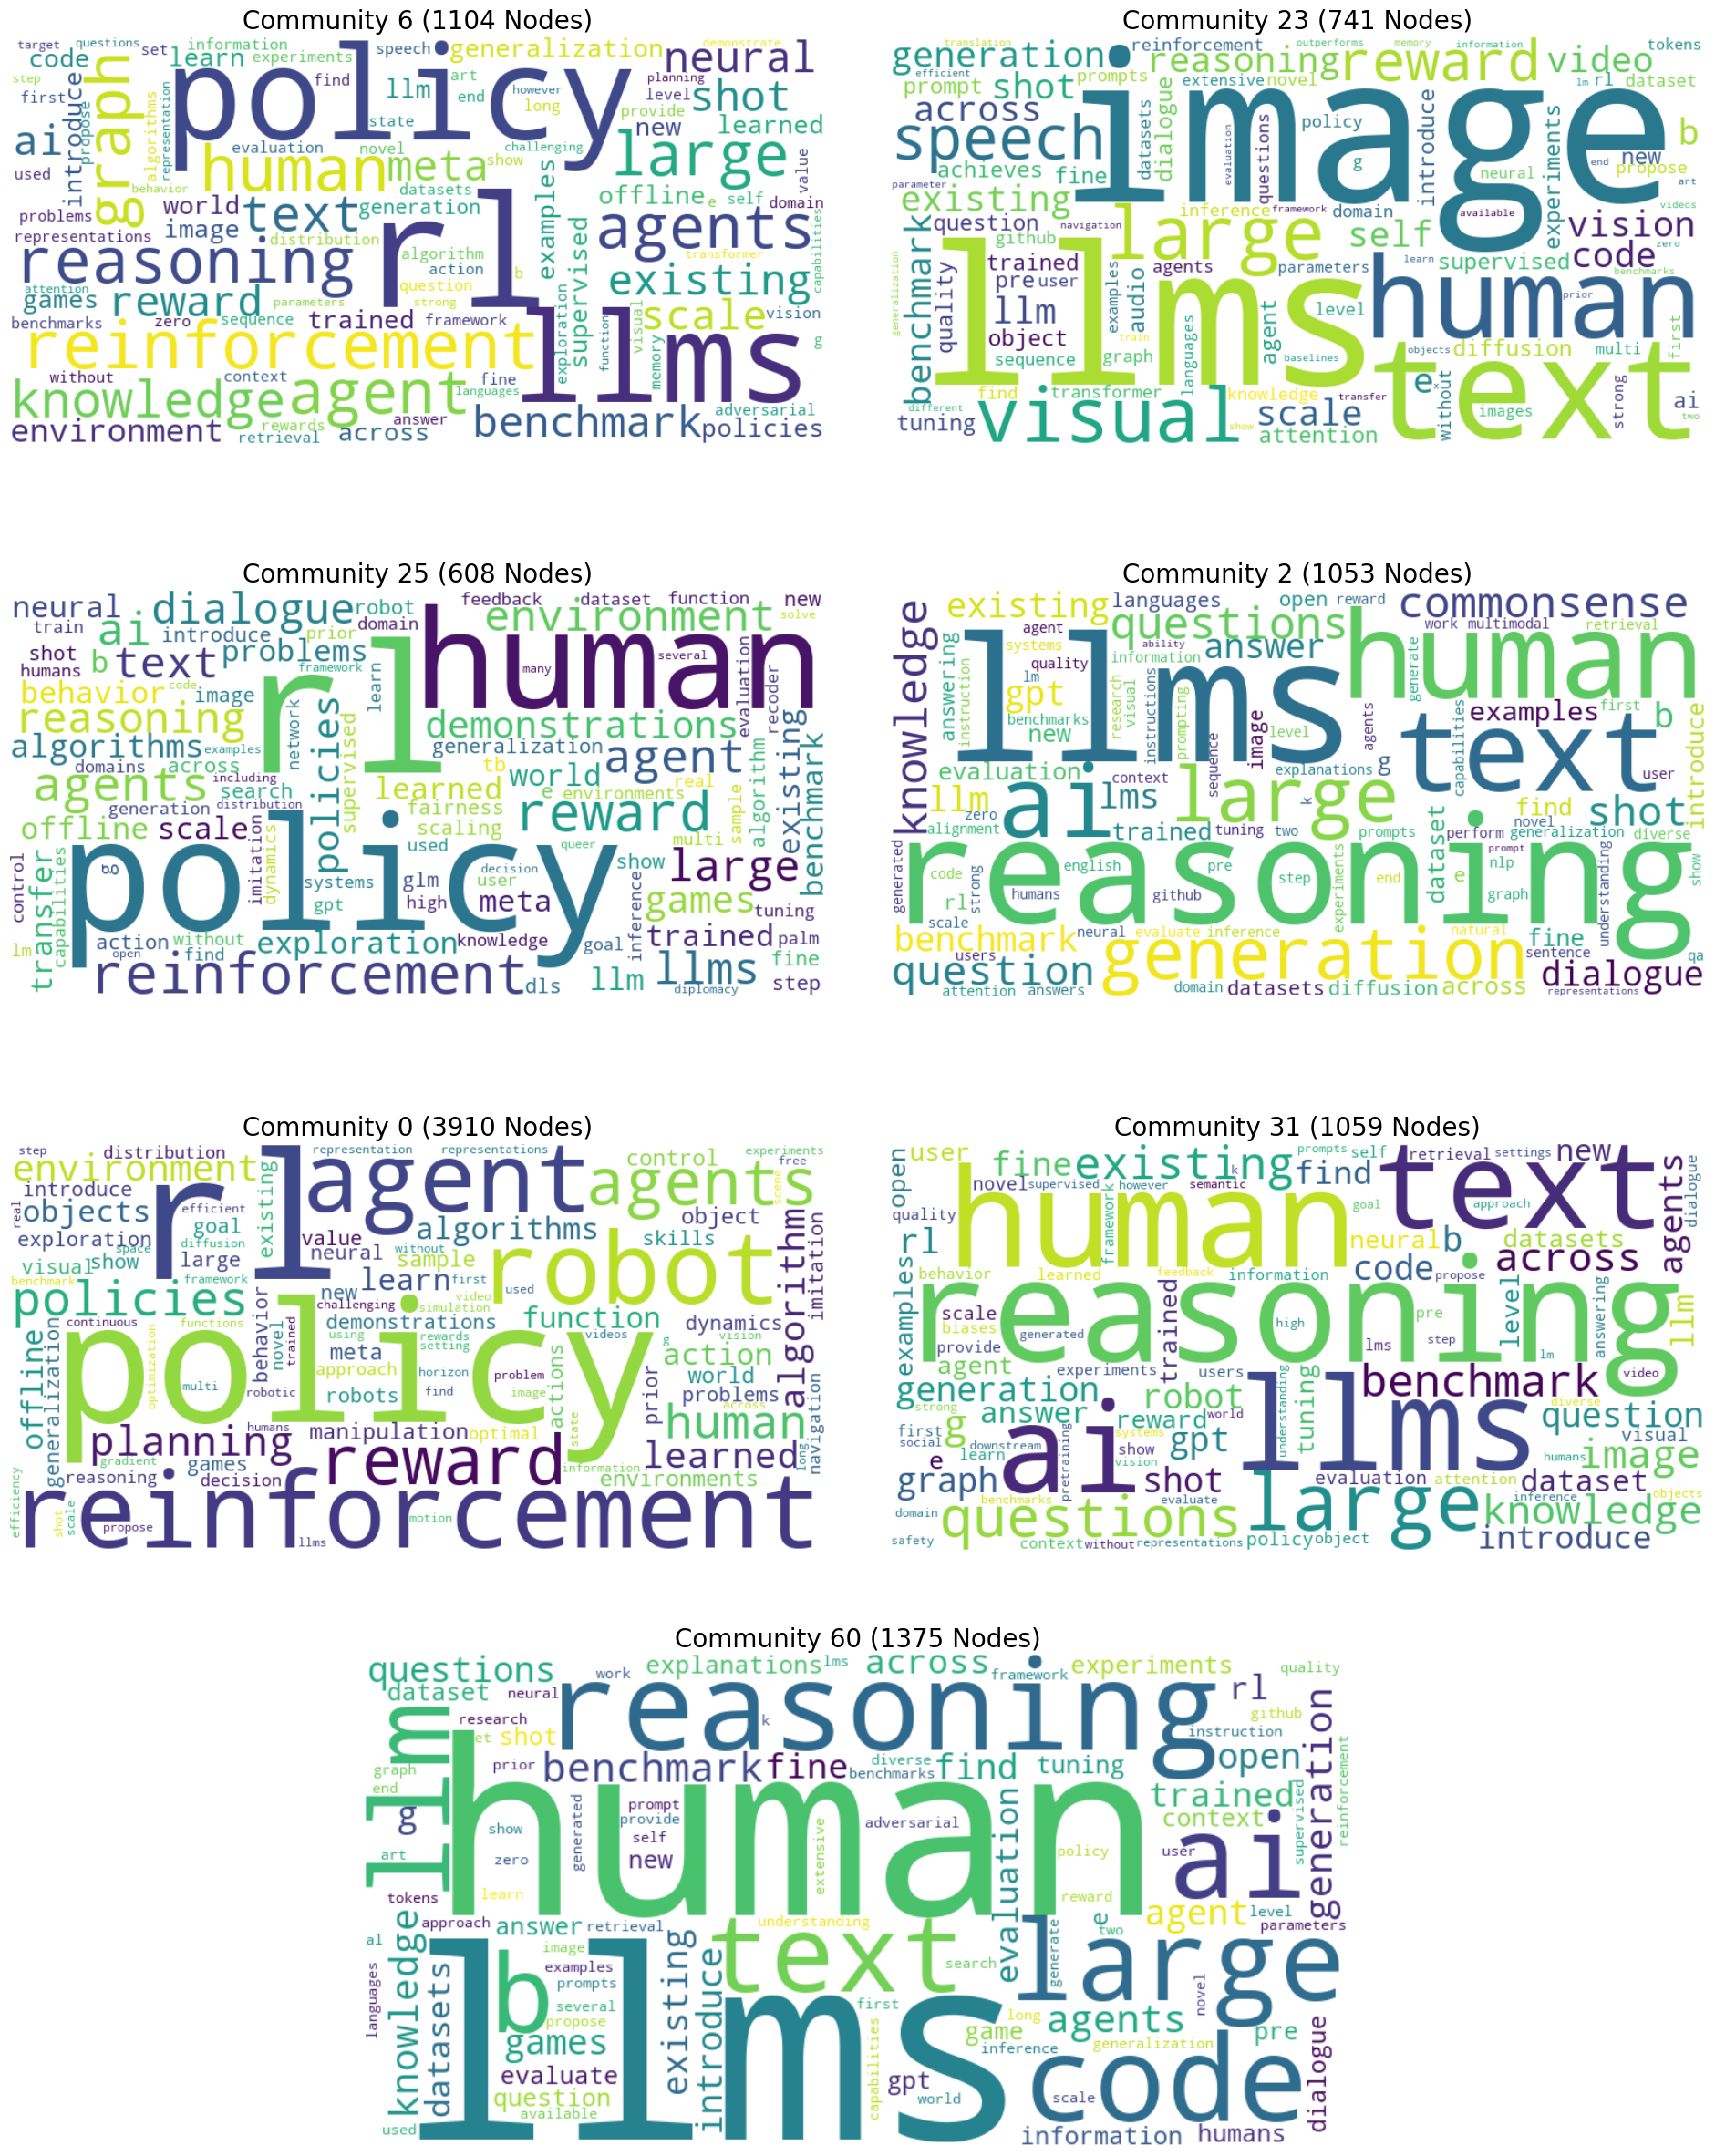

In [40]:
# Set up the word cloud parameters
wordcloud_params = {
    'background_color': 'white',
    'width': 800,
    'height': 400,
    'max_words': 100
}

# Create word clouds only for communities of interest
for community in communities_of_interest:
    if community in term_frequency_community:
        wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(term_frequency_community[community]['tf_idf'])
        term_frequency_community[community]['wordcloud_tf_idf'] = wordcloud

# Create figure
fig = plt.figure(figsize=(20, 25))  # Adjusted height for 4 rows

# Create gridspec with 4 rows and 2 columns
gs = fig.add_gridspec(4, 2)

# Create axes for the first 6 plots (3 rows x 2 columns)
axes = []
for row in range(3):
    for col in range(2):
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

# Create the last plot centered in the bottom row
ax_center = fig.add_subplot(gs[3, :])  # Span both columns
axes.append(ax_center)

# Plot word clouds for communities of interest
for i, community in enumerate(communities_of_interest):
    if community in term_frequency_community and 'wordcloud_tf_idf' in term_frequency_community[community]:
        axes[i].imshow(term_frequency_community[community]['wordcloud_tf_idf'], interpolation='bilinear')
        axes[i].set_title(f'Community {community} ({len(communities[community])} Nodes)', fontsize=20)
        axes[i].axis('off')

plt.tight_layout(pad=5)
plt.show()

<mark>To-Do: Interpretation of Wordclouds</mark>

### Investigating Communities of Interest

In [59]:
def get_top_community_researchers(community_id, n=10):
    # Get researchers from specified community
    community_citations = {researcher: citations for researcher, citations in sorted_researcher_citations 
                         if researcher in communities[community_id]}
    
    # Sort by citations and get top n researchers
    top_researchers = dict(sorted(community_citations.items(), 
                                key=lambda x: x[1],
                                reverse=True)[:n])
    
    return top_researchers

In [61]:
def get_top_community_papers(community_id, n=10):
    """
    Get the top n papers by citations for a specific community.
    
    Parameters:
    - community_id: ID of the community to analyze
    - n: Number of top papers to return (default=10)
    
    Returns:
    - Dictionary with paper titles as keys and citation counts as values
    """
    # Get all papers (with citations) that involve researchers from the specified community
    community_papers = {}
    
    # Get researchers from the specified community
    community_researchers = communities[community_id]
    
    # Iterate through all edges in the graph
    for u, v, edge_data in RG.edges(data=True):
        # Check if either researcher is in the community
        if u in community_researchers or v in community_researchers:
            title = edge_data.get('title')
            citations = edge_data.get('numCitedBy', 0)
            
            # Add paper to dictionary if not already present or update with higher citation count
            if title and (title not in community_papers or community_papers[title] < citations):
                community_papers[title] = citations
    
    # Sort papers by citation count and get top n
    sorted_papers = dict(sorted(community_papers.items(), 
                              key=lambda x: x[1], 
                              reverse=True)[:n])
    
    return sorted_papers

In [78]:
def print_community_info(community_id):
    print(f"--------------------------------Community {community_id}--------------------------------")
    print("\nTop 10 Researchers:")
    print("-" *30)
    researchers = get_top_community_researchers(community_id, 10)
    for i, (researcher, citations) in enumerate(researchers.items(), 1):
        print(f"{i}. {researcher} ({citations} citations)")

    print("\nTop 10 Papers:")
    print("-" * 30)
    papers = get_top_community_papers(community_id, 10)
    for i, (paper, citations) in enumerate(papers.items(), 1):
        print(f"{i}. {paper} ({citations} citations)")

In [79]:
print_community_info(25)

--------------------------------Community 25--------------------------------

Top 10 Researchers:
------------------------------
1. John Schulman (32242 citations)
2. P. Welinder (24595 citations)
3. J. Leike (23320 citations)
4. Wojciech Zaremba (22073 citations)
5. Jeff Wu (21983 citations)
6. Pamela Mishkin (18931 citations)
7. Jie Tang (18874 citations)
8. Chong Zhang (18837 citations)
9. Sandhini Agarwal (18744 citations)
10. Diogo Almeida (18723 citations)

Top 10 Papers:
------------------------------
1. Training language models to follow instructions with human feedback (9614 citations)
2. GPT-4 Technical Report (8972 citations)
3. Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (6524 citations)
4. Diffusion Models Beat GANs on Image Synthesis (5839 citations)
5. OpenAI Gym (4818 citations)
6. Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments (3973 citations)
7. On the Opportunities and Risks of Foundation

**Community 25: OpenAI**

- 10/10 work or have worked at OpenAI
- includes the two co-founders "John Schulmann" and "Wojciech Zaremba"
- 7/10 are still working there
- 3 have left the company: 2 joined Anthropic, one is founding a new start-up
- Papers are also closely related to OpenAI, including "GPT-4 Technical Report" and "OpenAI Gym"


In [80]:
print_community_info(23)

--------------------------------Community 23--------------------------------

Top 10 Researchers:
------------------------------
1. Devi Parikh (33969 citations)
2. Naman Goyal (12541 citations)
3. Angela Fan (12269 citations)
4. Sharan Narang (12210 citations)
5. Vedanuj Goswami (11605 citations)
6. Yuning Mao (11490 citations)
7. Shruti Bhosale (11457 citations)
8. Eric Michael Smith (11325 citations)
9. Sergey Edunov (11083 citations)
10. Madian Khabsa (10892 citations)

Top 10 Papers:
------------------------------
1. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization (17416 citations)
2. Llama 2: Open Foundation and Fine-Tuned Chat Models (8600 citations)
3. Segment Anything (4678 citations)
4. On the Opportunities and Risks of Foundation Models (3505 citations)
5. Making the V in VQA Matter: Elevating the Role of Image Understanding in Visual Question Answering (2759 citations)
6. HuBERT: Self-Supervised Speech Representation Learning by Masked Predi

**Community 23: Facebook/Meta**

- 10/10 work or have worked at Facebook/Meta
- 9/10 are still working there
- 1 has left the company: Devi Parikh, former Senior Director of GenAI is now building a new start-up
- Papers are also closely related to Facebook/Meta, e.g. the paper explaining the Llama-2 family


In [81]:
print_community_info(2)

--------------------------------Community 2--------------------------------

Top 10 Researchers:
------------------------------
1. Jason Wei (22435 citations)
2. S. Gu (19419 citations)
3. Barret Zoph (18210 citations)
4. Percy Liang (16513 citations)
5. Alex Ray (15492 citations)
6. Stefano Ermon (14614 citations)
7. Amanda Askell (14472 citations)
8. Mohit Bansal (14090 citations)
9. Jacob Hilton (13728 citations)
10. Christopher D. Manning (13202 citations)

Top 10 Papers:
------------------------------
1. Training language models to follow instructions with human feedback (9614 citations)
2. GPT-4 Technical Report (8972 citations)
3. Chain of Thought Prompting Elicits Reasoning in Large Language Models (6163 citations)
4. ALBERT: A Lite BERT for Self-supervised Learning of Language Representations (5966 citations)
5. Neural Architecture Search with Reinforcement Learning (5133 citations)
6. On the Opportunities and Risks of Foundation Models (3505 citations)
7. Density estimation u

**no clear community**

In [82]:
print_community_info(6)

--------------------------------Community 6--------------------------------

Top 10 Researchers:
------------------------------
1. N. Houlsby (36510 citations)
2. Mostafa Dehghani (36346 citations)
3. O. Vinyals (19338 citations)
4. Denny Zhou (14610 citations)
5. T. Lillicrap (14094 citations)
6. David Silver (13784 citations)
7. D. Hassabis (13249 citations)
8. Yujia Li (12590 citations)
9. Simon Osindero (12532 citations)
10. Z. Chen (12168 citations)

Top 10 Papers:
------------------------------
1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (31414 citations)
2. Conditional Generative Adversarial Nets (9774 citations)
3. GPT-4 Technical Report (8972 citations)
4. Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation (6524 citations)
5. Overcoming catastrophic forgetting in neural networks (6482 citations)
6. Chain of Thought Prompting Elicits Reasoning in Large Language Models (6163 citations)
7. ALBERT: A

**Community 6: Google/DeepMind**

- 10/10 work or have worked at Google
- 10/10 are still working there
- includes Deepmind CEO Demis Hassabis
- Papers are also closely related to Google, e.g. the paper explaining the Gemini family. Interestingly, also the technical report of GPT-4 is co-authored by one researcher of this community. 


In [83]:
print_community_info(31)

--------------------------------Community 31--------------------------------

Top 10 Researchers:
------------------------------
1. Guillem Cucurull (26245 citations)
2. Michael S. Bernstein (10814 citations)
3. Marie-Anne Lachaux (10475 citations)
4. Thibaut Lavril (10271 citations)
5. Weizhu Chen (10191 citations)
6. Cynthia Gao (10095 citations)
7. Ranjay Krishna (10087 citations)
8. Jiajun Wu (10026 citations)
9. Yixin Nie (9768 citations)
10. J. Leskovec (9647 citations)

Top 10 Papers:
------------------------------
1. Graph Attention Networks (17607 citations)
2. Llama 2: Open Foundation and Fine-Tuned Chat Models (8600 citations)
3. LoRA: Low-Rank Adaptation of Large Language Models (6860 citations)
4. Visual Genome: Connecting Language and Vision Using Crowdsourced Dense Image Annotations (5285 citations)
5. On the Opportunities and Risks of Foundation Models (3505 citations)
6. Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting (2945 citations)
7

**no clear community**

In [84]:
print_community_info(0)

--------------------------------Community 0--------------------------------

Top 10 Researchers:
------------------------------
1. S. Levine (66585 citations)
2. P. Abbeel (59345 citations)
3. Chelsea Finn (32452 citations)
4. S. Savarese (19143 citations)
5. Petar Velickovic (18331 citations)
6. Arantxa Casanova (17620 citations)
7. Adriana Romero (17607 citations)
8. Trevor Darrell (16200 citations)
9. J. Tenenbaum (14797 citations)
10. Razvan Pascanu (13991 citations)

Top 10 Papers:
------------------------------
1. Graph Attention Networks (17607 citations)
2. Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks (10801 citations)
3. Conditional Generative Adversarial Nets (9774 citations)
4. Reinforcement Learning: A Survey (8767 citations)
5. Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor (7227 citations)
6. Overcoming catastrophic forgetting in neural networks (6482 citations)
7. Chain of Thought Prompting Elicits R

**no clear community**

In [85]:
print_community_info(60)

--------------------------------Community 60--------------------------------

Top 10 Researchers:
------------------------------
1. Carlos Guestrin (18020 citations)
2. Sameer Singh (17024 citations)
3. P. Christiano (15523 citations)
4. J. Weston (12003 citations)
5. Tomas Mikolov (10576 citations)
6. Dario Amodei (10129 citations)
7. Luke Zettlemoyer (9557 citations)
8. Douwe Kiela (6473 citations)
9. Margaret Mitchell (6269 citations)
10. Mikel Artetxe (5839 citations)

Top 10 Papers:
------------------------------
1. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier (15069 citations)
2. Training language models to follow instructions with human feedback (9614 citations)
3. Distributed Representations of Sentences and Documents (8988 citations)
4. Neural Ordinary Differential Equations (4406 citations)
5. Pre-train, Prompt, and Predict: A Systematic Survey of Prompting Methods in Natural Language Processing (3266 citations)
6. A Neural Attention Model for Abstr

### Network Visualization w/ Communities

In [ ]:
# Node sizes based on degree
min_size, max_size = 1, 100
degrees = [backbone_disparity_gcc.degree(node) for node in backbone_disparity_gcc.nodes]
if max(degrees) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (degree / max(degrees)) for degree in degrees]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Node colors based on citations
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Normalize citations for color mapping
    norm = mcolors.Normalize(vmin=min(citations), vmax=max(citations))
    cmap = cm.viridis  # Use the Viridis colormap
    node_colors = [cmap(norm(citation)) for citation in citations]
else:
    node_colors = ["lightgrey" for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Degree-based sizes
    edge_color="grey",
    node_color=node_colors,  # Citation-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a colorbar for the citation values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Citations", fontsize=12)

# Set the title and show the plot
plt.title("Network Visualization with Degree-Based Sizes and Citation-Based Colors", fontsize=14)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Node colors based on community labels
community_colors = {25: "red", 23: "blue", 6: "gold"}  # Define the colors for specific communities
node_colors = []

for node in backbone_disparity_gcc.nodes:
    # Find the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break
    
    # Assign color based on community label
    if community_label in community_colors:
        node_colors.append(community_colors[community_label])
    else:
        node_colors.append("black")  # Default to black for other communities

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Community-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Sizes and Community-Based Colors", fontsize=14)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Node colors based on community labels
community_colors = {25: "black", 23: "blue", 6: "gold"}  # Define the colors for specific communities
node_colors = []

for node in backbone_disparity_gcc.nodes:
    # Find the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break
    
    # Assign color based on community label
    if community_label in community_colors:
        node_colors.append(community_colors[community_label])
    else:
        node_colors.append("lightslategrey")  # Default to black for other communities

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Community-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Sizes and Community-Based Colors", fontsize=14)
plt.show()

In [ ]:
# Generate a distinct color for each community
community_labels = list(communities.keys())  # Get all community labels
cmap = cm.get_cmap('tab20', len(community_labels))  # Use 'tab20' for distinct colors
community_colors = {label: mcolors.to_hex(cmap(i)) for i, label in enumerate(community_labels)}

# Assign node colors based on their community
node_colors = []
for node in backbone_disparity_gcc.nodes:
    # Find the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break
    
    # Assign the color based on the community label
    if community_label is not None:
        node_colors.append(community_colors[community_label])
    else:
        node_colors.append("black")  # Default to black if no community is found

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Community-based colors
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a legend for the communities
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10) for color in community_colors.values()]
labels = [f'Community {label}' for label in community_labels]
ax.legend(handles, labels, loc='upper right', title="Communities")

# Set the title and show the plot
plt.title("Network Visualization with Citation-Based Sizes and Community-Based Colors", fontsize=14)
plt.show()


In [ ]:
top_communities = [community[0] for community in sorted_communities_by_avg[:10]]
specific_colors = {25: "red", 23: "blue", 6: "yellow"}  # Custom colors for 25, 23, and 6

# Assign unique colors for the remaining communities in the top 10
remaining_communities = [comm for comm in top_communities if comm not in specific_colors]
color_map = cm.get_cmap('tab10', len(remaining_communities))  # Generate distinct colors
remaining_colors = {community: mcolors.to_hex(color_map(i)) for i, community in enumerate(remaining_communities)}

# Combine the specific and remaining colors
community_colors = {**specific_colors, **remaining_colors}

# Assign colors to nodes based on their community
node_colors = []
for node in backbone_disparity_gcc.nodes:
    # Determine the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break

    # Assign colors based on community label or black if not in top 10
    if community_label in top_communities:
        node_colors.append(community_colors.get(community_label, "black"))
    else:
        node_colors.append("black")

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Colors for top communities or black
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a legend for the top communities
handles = [
    plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f"Community {community}")
    for community, color in zip(top_communities, [community_colors[community] for community in top_communities])
]

# Add the legend to the plot
ax.legend(handles=handles, loc='upper right', title="Top Communities")

# Set the title and show the plot
plt.title("Network Visualization with Top 10 Community Colors and Black for Others", fontsize=14)
plt.show()

In [ ]:
# Specify colors manually for all top 5 communities
manual_colors = {25: "red", 23: "blue", 6: "yellow", 2: "green", 31: "purple"}

# Assign colors to nodes based on their community
node_colors = []
for node in backbone_disparity_gcc.nodes:
    # Determine the community label of the node
    community_label = None
    for label, members in communities.items():
        if node in members:
            community_label = label
            break

    # Assign colors based on community label or black if not in top 5
    if community_label in manual_colors:
        node_colors.append(manual_colors.get(community_label, "black"))
    else:
        node_colors.append("black")

# Node sizes based on citations
min_size, max_size = 1, 100
citations = [researcher_citations.get(node, 0) for node in backbone_disparity_gcc.nodes]
if max(citations) > 0:  # Avoid division by zero
    node_sizes = [min_size + (max_size - min_size) * (citation / max(citations)) for citation in citations]
else:
    node_sizes = [min_size for _ in backbone_disparity_gcc.nodes]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

nx.draw(
    backbone_disparity_gcc,
    pos=positions_backbone_disparity,
    node_size=node_sizes,  # Citation-based sizes
    edge_color="grey",
    node_color=node_colors,  # Colors for top communities or black
    width=0.5,
    alpha=0.5,
    ax=ax
)

# Add a legend for the top communities with manual colors
handles = [
    plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f"Community {community}")
    for community, color in manual_colors.items()
]

# Add a legend entry for "Other Communities" in black
handles.append(
    plt.Line2D([0], [0], marker='o', color="black", linestyle='', markersize=10, label="Other Communities")
)

# Add the legend to the plot
ax.legend(handles=handles, loc='upper right', title="Top Communities")

# Set the title and show the plot
plt.title("Network Visualization with Manually Specified Colors for Top 5 Communities", fontsize=14)
plt.show()

#### further ideas
- shortest path lengths for all nodes (within most important communities)
- redo wordclouds for top 10 citation communities 
- reload everything + cs.ML 
